<div style="text-align:center; font-size:24px">Capstone AI Workflow</div>

# Business Problem

Given a MNIST dataset, we find the best model to this topic: Recognition handwritten digits. 

The MNIST database is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets.

Please see more detail in [1].

**References**

[1] The MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/) 

[2] https://github.com/pytorch/examples/blob/master/mnist/main.py

[3] https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py

[4] https://towardsdatascience.com/unit-testing-and-logging-for-data-science-d7fb8fd5d217

[5] https://github.com/CoreyMSchafer/code_snippets/blob/master/Decorators/decorators.py

[6] https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html?highlight=mnist

[7] https://nextjournal.com/gkoehler/pytorch-mnist

# Data Setttings

In [1], the authors described the MNIST corpus as follows:

+ train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
+ train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
+ t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
+ t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes) 

The images are normalized in 28x28, that are preserved the aspect ratio from original black and white images (NIST, 20x20), by computing the center of mass of the pixels and translating the image to position this point at the center of 28x28 field.


# Approach

## Baseline

In this baseline, we choose random result, that is in [0, 9], for each test vector input.



## Traditional Techniques


In [1]:

import time
import logging
from functools import wraps
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

%matplotlib inline
warnings.filterwarnings("ignore")

COL_NAME_METHOD_NAME = "Testcase"
COL_NAME_ACCURACY = "Accuracy"
COL_NAME_DURATION = "Duration"

COL_NAMES = [COL_NAME_METHOD_NAME, COL_NAME_ACCURACY]


class decorator_class(object):

    def __init__(self, original_function):
        self.original_function = original_function

    def __call__(self, *args, **kwargs):
        print('call method before {}'.format(self.original_function.__name__))
        self.original_function(*args, **kwargs)


def logger(original_func):
    logging.basicConfig(filename='{}.log'.format(original_func.__name__),
                        level=logging.INFO)

    @wraps(original_func)
    def wrapper(*args, **kwargs):
        logging.info('Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return original_func(*args, **kwargs)
    return wrapper


def cls_timer(original_func):
    @wraps(original_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = original_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(original_func.__name__, t2))
        return result
    return wrapper


def get_dataset_mnist():
    # new version: fetch_openml; old version: fetch_mldata('MNIST original')
    mnist = fetch_openml('mnist_784')
    X = mnist.data.astype('float64')
    y = mnist.target
    return (X, y)

class Normalize(object):
    def normalize(self, X_train, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_test)

    def inverse(self, X_train, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_test)

def split(X, y, splitRatio):
    X_train = X[:splitRatio]
    y_train = y[:splitRatio]
    X_test = X[splitRatio:]
    y_test = y[splitRatio:]
    return (X_train, y_train, X_test, y_test)



class algo_logistic_regression(object):

    @logger
    @cls_timer
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test

    @logger
    @cls_timer
    def fit(self):
        normalizer = Normalize()
        self.X_train, self.X_test = normalizer.normalize(self.X_train, self.X_test)
        train_samples = self.X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight='balanced')
        self.classifier.fit(self.X_train, self.y_train)
        self.train_y_predicted = self.classifier.predict(self.X_train)
        self.train_accuracy = round(np.mean(self.train_y_predicted.ravel() == self.y_train.ravel()) * 100, 2)
        self.train_confusion_matrix = confusion_matrix(self.y_train, self.train_y_predicted)

        return self.train_accuracy

    @logger
    @cls_timer
    def predict(self):
        self.test_y_predicted = self.classifier.predict(self.X_test)
        self.test_accuracy = round(np.mean(self.test_y_predicted.ravel() == self.y_test.ravel()) * 100, 2)
        self.test_confusion_matrix = confusion_matrix(self.y_test, self.test_y_predicted)
        self.report = classification_report(self.y_test, self.test_y_predicted)
        print("Classification report for classifier Logistic Regression:\n %s\n" % (self.report))
        return self.test_accuracy

    @logger
    @cls_timer
    def predict_dummy(self):
        """Dummy prediction with baseline obtained result between [0,9]
        """
        self.test_y_predicted_baseline = np.array([str(x) for x in np.random.randint(10, size=len(self.X_test))])
        self.test_accuracy_baseline = round(np.mean(self.test_y_predicted_baseline.ravel() == self.y_test.ravel() * 100), 2)
        self.test_confusion_matrix_baseline = confusion_matrix(self.y_test, self.test_y_predicted_baseline)
        self.report_baseline = classification_report(self.y_test, self.test_y_predicted_baseline)
        print("Classification report for classifier - Baseline:\n %s\n" % (self.report_baseline))
        return self.test_accuracy_baseline


class algo_multilayer_perceptron(object):

    @logger
    @cls_timer
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test

    @logger
    @cls_timer
    def fit(self):
        normalizer = Normalize()
        self.X_train, self.X_test = normalizer.normalize(self.X_train, self.X_test)
        train_samples = self.X_train.shape[0]
        self.classifier = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                                        solver='sgd', verbose=10, random_state=1,
                                        learning_rate_init=.1)
        self.classifier.fit(self.X_train, self.y_train)
        self.train_y_predicted = self.classifier.predict(self.X_train)
        self.train_accuracy = round(np.mean(self.train_y_predicted.ravel() == self.y_train.ravel()) * 100, 2)
        self.train_confusion_matrix = confusion_matrix(self.y_train, self.train_y_predicted)
        return self.train_accuracy

    @logger
    @cls_timer
    def predict(self):
        self.test_y_predicted = self.classifier.predict(self.X_test)
        self.test_accuracy = round(np.mean(self.test_y_predicted.ravel() == self.y_test.ravel()) * 100, 2)
        self.test_confusion_matrix = confusion_matrix(self.y_test, self.test_y_predicted)
        self.report = classification_report(self.y_test, self.test_y_predicted)
        print("Classification report for classifier Logistic Regression:\n %s\n" % (self.report))
        return self.test_accuracy

    @logger
    @cls_timer
    def predict_dummy(self):
        """Dummy prediction with baseline obtained result between [0,9]
        """
        self.test_y_predicted_baseline = np.array([str(x) for x in np.random.randint(10, size=len(self.X_test))])
        self.test_accuracy_baseline = round(np.mean(self.test_y_predicted_baseline.ravel() == self.y_test.ravel() * 100), 2)
        self.test_confusion_matrix_baseline = confusion_matrix(self.y_test, self.test_y_predicted_baseline)
        self.report_baseline = classification_report(self.y_test, self.test_y_predicted_baseline)
        print("Classification report for classifier - Baseline:\n %s\n" % (self.report_baseline))
        return self.test_accuracy_baseline

# Main functions

### Unittest for logger and cls_timer
# @logger
# @cls_timer
# def display_info(name, age):
#     time.sleep(1)
#     print('display_info ran with arguments ({}, {})'.format(name, age))
# display_info('Tom', 22)

### Logistic Regression

In [2]:
values = []

# Logistic Regression
X,y = get_dataset_mnist()
print('MNIST:', X.shape, y.shape)

splitRatio = 60000
X_train, y_train, X_test, y_test = split(X, y, splitRatio)

# ----------------------------------------------------------------------------
t0 = time.time()
np.random.seed(31337)
ta = algo_logistic_regression(X_train, y_train, X_test, y_test)
train_accuracy = ta.fit()

# ----------------------------------------------------------------------------
print("-" * 72)
test_accuracy_baseline = ta.predict_dummy()
print()
print('Test Accuracy - Baseline:', test_accuracy_baseline,'\n')
print("Test confusion matrix - Baseline:\n%s\n" % ta.test_confusion_matrix_baseline)

# Add Test Accuracy - Baseline
method_name = "Baseline for Test-set (Random result)"
values.append((method_name, test_accuracy_baseline))
# ----------------------------------------------------------------------------
print()
print("-" * 72)
print("Train Accuracy - Logistic Regression:", train_accuracy,'\n')
print("Train confusion matrix:\n%s\n" % ta.train_confusion_matrix)

# Add Train Accuracy
method_name = "Train Accuracy - Logistic Regression"
values.append((method_name, train_accuracy))
# ----------------------------------------------------------------------------
print("-" * 72)
test_accuracy = ta.predict()
print()
print('Test Accuracy - LogisticRegression:', test_accuracy,'\n')
print("Test confusion matrix:\n%s\n" % ta.test_confusion_matrix)

# Add Test Accuracy
method_name = "Logistic Regression"
values.append((method_name, test_accuracy))

MNIST: (70000, 784) (70000,)
__init__ ran in: 2.1457672119140625e-06 sec
fit ran in: 15.04773211479187 sec
------------------------------------------------------------------------
Classification report for classifier - Baseline:
               precision    recall  f1-score   support

           0       0.11      0.12      0.11       980
           1       0.11      0.10      0.10      1135
           2       0.12      0.11      0.11      1032
           3       0.10      0.10      0.10      1010
           4       0.11      0.11      0.11       982
           5       0.09      0.10      0.09       892
           6       0.09      0.10      0.10       958
           7       0.10      0.10      0.10      1028
           8       0.10      0.10      0.10       974
           9       0.11      0.11      0.11      1009

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000


predict_du

Sparsity with L1 penalty: 93.66%
Example run in 15.799 s


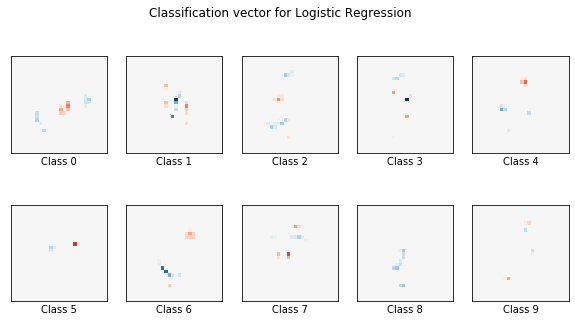

In [3]:
# ----------------------------------------------------------------------------
sparsity = np.mean(ta.classifier.coef_ == 0) * 100

print("Sparsity with L1 penalty: %.2f%%" % sparsity)

coef = ta.classifier.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for Logistic Regression')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()

### Multilayer Perceptron

In [4]:
print("-" * 72)
t0 = time.time()
np.random.seed(31337)
ta = algo_multilayer_perceptron(X_train, y_train, X_test, y_test)
# ----------------------------------------------------------------------------
train_accuracy = ta.fit()
print()
print("Train Accuracy - MLP:", train_accuracy,'\n')
print("Train confusion matrix:\n%s\n" % ta.train_confusion_matrix)

# Add Train Accuracy
method_name = "Train Accuracy - MLP"
values.append((method_name, train_accuracy))

# ----------------------------------------------------------------------------
print("-" * 72)
test_accuracy = ta.predict()
print()
print('Test Accuracy - MLP:', test_accuracy,'\n')
print("Test confusion matrix:\n%s\n" % ta.test_confusion_matrix)

# Add Test Accuracy
method_name = "Multilayer Perceptron"
values.append((method_name, test_accuracy))

------------------------------------------------------------------------
__init__ ran in: 3.5762786865234375e-06 sec
Iteration 1, loss = 0.32062846
Iteration 2, loss = 0.15380246
Iteration 3, loss = 0.11584796
Iteration 4, loss = 0.09353969
Iteration 5, loss = 0.07927847
Iteration 6, loss = 0.07134286
Iteration 7, loss = 0.06220003
Iteration 8, loss = 0.05481447
Iteration 9, loss = 0.04937818
Iteration 10, loss = 0.04596632
fit ran in: 13.414228200912476 sec

Train Accuracy - MLP: 98.77 

Train confusion matrix:
[[5878    0    6    2    0    9   10    5    6    7]
 [   1 6626   33   19    4    0   10   20   15   14]
 [   2    2 5862   42    5    1    6   26    8    4]
 [   0    0   14 6068    0   17    0    4   17   11]
 [   1    1    6    4 5729    1   19    9    1   71]
 [   4    0    1   11    0 5375   10    2    5   13]
 [   9    0    0    0    2    7 5892    1    7    0]
 [   0    2   14   23    4    1    1 6200    1   19]
 [   2    5    3   60    1   13    6    4 5719   38]
 [   

### Unittest

In [5]:
import unittest

class TestInput(unittest.TestCase):
  
    @classmethod
    def setUpClass(cls):
        # print('setupClass')   
        pass

    @classmethod
    def tearDownClass(cls): 
        # print('teardownClass')
        pass

    def setUp(self):
        print('setUp') 
        X, y = get_dataset_mnist()
        splitRatio = 60000
        self.X_train, self.y_train, self.X_test, self.y_test = split(X, y, splitRatio) 
        self.train_accuracy = 72.65
        self.train_confusion_matrix = np.matrix([[5465,    7,   31,   25,   45,   18,  196,   59,   71,   6],
                                                 [   3, 6481,   98,   45,    2,   29,   25,   40,   18,   1],
                                                 [ 339,  478, 3603,  165,  286,   19,  689,  210,  115,  54],
                                                 [ 143,  255,  224, 4521,   60,  256,  102,  146,  241, 183],
                                                 [ 106,  136,   23,   51, 4521,  331,  198,  150,   84, 242],
                                                 [ 414,  214,   85, 1032,  402, 2261,  292,  408,  186, 127],
                                                 [ 189,   96,   91,   53,  157,  230, 5038,   29,   35,   0],
                                                 [ 209,  203,  183,   38,  142,   16,   25, 5108,   50, 291],
                                                 [  72,  770,  181,  692,   72,  191,  352,   48, 3317, 156],
                                                 [ 167,  182,   48,  257,  625,  265,  120,  782,  227, 3276]])
        
        self.test_accuracy = 73.18
        self.test_confusion_matrix = np.matrix([
            [ 922,    2,    2,    3,    3,    1,   36,    4,    7,    0],
            [   0, 1090,   18,   11,    0,    0,    5,    5,    6,    0],
            [  66,   94,  636,   30,   40,    2,   98,   33,   25,    8],
            [  21,   30,   31,  766,    7,   44,   18,   32,   38,   23],
            [  15,   20,    2,    8,  748,   58,   45,   26,   18,   42],
            [  61,   27,   12,  185,   74,  368,   58,   65,   23,   19],
            [  36,   10,   16,    8,   26,   42,  804,    8,    7,    1],
            [  23,   43,   47,    6,   16,    3,    6,  830,   10,   44],
            [  14,   98,   27,  100,   10,   33,   70,    9,  583,   30],
            [  21,   29,    9,   33,  129,   43,   28,  108,   38,  571]])

        
    def tearDown(self):
        # print('tearDown')
        pass
        
        
    def test_fit(self):     
        np.random.seed(31337)
        self.ta = algo_logistic_regression(self.X_train, self.y_train, self.X_test, self.y_test)
        self.assertEqual(self.ta.fit(), self.train_accuracy) 
        self.assertEqual(self.ta.train_confusion_matrix.tolist(), self.train_confusion_matrix.tolist())  
  

    def test_predict(self):
        np.random.seed(31337)
        self.ta = algo_logistic_regression(self.X_train, self.y_train, self.X_test, self.y_test)
        self.ta.fit()
        self.assertEqual(self.ta.predict(), self.test_accuracy)
        self.assertEqual(self.ta.train_confusion_matrix.tolist(), self.train_confusion_matrix.tolist()) 

#run tests 
unittest.main(argv=['first-arg-is-ignored'], exit=False)

setUp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


__init__ ran in: 2.6226043701171875e-06 sec


.

fit ran in: 15.77181339263916 sec
setUp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


__init__ ran in: 1.9073486328125e-06 sec
fit ran in: 15.43849515914917 sec


.

Classification report for classifier Logistic Regression:
               precision    recall  f1-score   support

           0       0.78      0.94      0.85       980
           1       0.76      0.96      0.85      1135
           2       0.80      0.62      0.69      1032
           3       0.67      0.76      0.71      1010
           4       0.71      0.76      0.74       982
           5       0.62      0.41      0.50       892
           6       0.69      0.84      0.76       958
           7       0.74      0.81      0.77      1028
           8       0.77      0.60      0.67       974
           9       0.77      0.57      0.65      1009

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.72     10000
weighted avg       0.73      0.73      0.72     10000


predict ran in: 0.31712937355041504 sec



----------------------------------------------------------------------
Ran 2 tests in 65.206s

OK


### Statistic and Analysis

In [6]:
print("-" * 36)
df = pd.DataFrame(columns=COL_NAMES, data=values)
df

------------------------------------


,Testcase,Accuracy
0,Baseline for Test-set (Random result),0.00
1,Train Accuracy - Logistic Regression,72.65
2,Logistic Regression,73.18
3,Train Accuracy - MLP,98.77
4,Multilayer Perceptron,97.04


## Deep Neural Network - Convolutional Neural Network

In [7]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

In [8]:
seed = 1         # random seed (default: 1)
no_cuda = False  # disables CUDA training
batch_size = 32  # 64
test_batch_size = 500
lr = 1.0     # Learning Rate
gamma = 0.7  # Learning rate step gamma (default: 0.7)
epochs = 2   # number of epochs to train (default: 14)
log_interval = 2 # how many batches to wait before logging training status
save_model = True  # For Saving the current Model
dir_data_path = "./var/"

use_cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dir_data_path, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(dir_data_path, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

### Review some samples in Test set

Example data - shape =  torch.Size([500, 1, 28, 28])

This means we have 500 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one).
We can plot some of them using matplotlib.


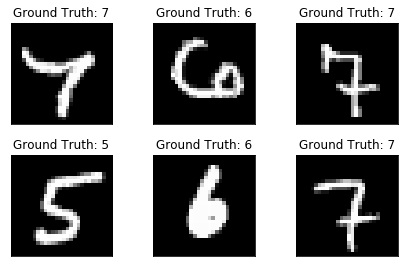

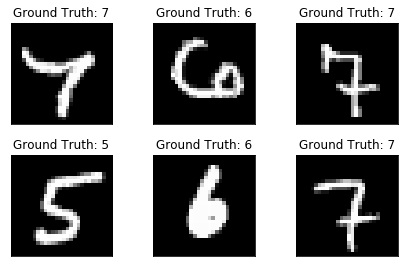

In [9]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print("Example data - shape = ", example_data.shape)

# torch.Size([500, 1, 28, 28])
print()
print("This means we have 500 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one).\nWe can plot some of them using matplotlib.")

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Train and Test Phase with CNN

In [10]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train(log_interval, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

if save_model:
    torch.save(model.state_dict(), dir_data_path + "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318299
Train Epoch: 1 [64/60000 (0%)]	Loss: 2.356526
Train Epoch: 1 [128/60000 (0%)]	Loss: 2.312636
Train Epoch: 1 [192/60000 (0%)]	Loss: 1.732391
Train Epoch: 1 [256/60000 (0%)]	Loss: 1.988776
Train Epoch: 1 [320/60000 (1%)]	Loss: 1.423388
Train Epoch: 1 [384/60000 (1%)]	Loss: 0.875975
Train Epoch: 1 [448/60000 (1%)]	Loss: 1.106432
Train Epoch: 1 [512/60000 (1%)]	Loss: 0.655509
Train Epoch: 1 [576/60000 (1%)]	Loss: 1.397822
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.419117
Train Epoch: 1 [704/60000 (1%)]	Loss: 1.099620
Train Epoch: 1 [768/60000 (1%)]	Loss: 0.776829
Train Epoch: 1 [832/60000 (1%)]	Loss: 0.749775
Train Epoch: 1 [896/60000 (1%)]	Loss: 0.527959
Train Epoch: 1 [960/60000 (2%)]	Loss: 0.594013
Train Epoch: 1 [1024/60000 (2%)]	Loss: 0.733167
Train Epoch: 1 [1088/60000 (2%)]	Loss: 0.655955
Train Epoch: 1 [1152/60000 (2%)]	Loss: 0.279198
Train Epoch: 1 [1216/60000 (2%)]	Loss: 0.875672
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.339386
Train Epoch

Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.236232
Train Epoch: 1 [10944/60000 (18%)]	Loss: 0.088301
Train Epoch: 1 [11008/60000 (18%)]	Loss: 0.366962
Train Epoch: 1 [11072/60000 (18%)]	Loss: 0.204014
Train Epoch: 1 [11136/60000 (19%)]	Loss: 0.143583
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.210334
Train Epoch: 1 [11264/60000 (19%)]	Loss: 0.102122
Train Epoch: 1 [11328/60000 (19%)]	Loss: 0.102366
Train Epoch: 1 [11392/60000 (19%)]	Loss: 0.177041
Train Epoch: 1 [11456/60000 (19%)]	Loss: 0.138845
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.261450
Train Epoch: 1 [11584/60000 (19%)]	Loss: 0.197470
Train Epoch: 1 [11648/60000 (19%)]	Loss: 0.233641
Train Epoch: 1 [11712/60000 (20%)]	Loss: 0.135248
Train Epoch: 1 [11776/60000 (20%)]	Loss: 0.071971
Train Epoch: 1 [11840/60000 (20%)]	Loss: 0.447781
Train Epoch: 1 [11904/60000 (20%)]	Loss: 0.079275
Train Epoch: 1 [11968/60000 (20%)]	Loss: 0.199913
Train Epoch: 1 [12032/60000 (20%)]	Loss: 0.210040
Train Epoch: 1 [12096/60000 (20%)]	Loss: 0.247014


Train Epoch: 1 [21376/60000 (36%)]	Loss: 0.196032
Train Epoch: 1 [21440/60000 (36%)]	Loss: 0.040962
Train Epoch: 1 [21504/60000 (36%)]	Loss: 0.002538
Train Epoch: 1 [21568/60000 (36%)]	Loss: 0.059722
Train Epoch: 1 [21632/60000 (36%)]	Loss: 0.133829
Train Epoch: 1 [21696/60000 (36%)]	Loss: 0.126359
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.135060
Train Epoch: 1 [21824/60000 (36%)]	Loss: 0.619559
Train Epoch: 1 [21888/60000 (36%)]	Loss: 0.078371
Train Epoch: 1 [21952/60000 (37%)]	Loss: 0.208107
Train Epoch: 1 [22016/60000 (37%)]	Loss: 0.083521
Train Epoch: 1 [22080/60000 (37%)]	Loss: 0.393394
Train Epoch: 1 [22144/60000 (37%)]	Loss: 0.111635
Train Epoch: 1 [22208/60000 (37%)]	Loss: 0.090901
Train Epoch: 1 [22272/60000 (37%)]	Loss: 0.117206
Train Epoch: 1 [22336/60000 (37%)]	Loss: 0.099294
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.296972
Train Epoch: 1 [22464/60000 (37%)]	Loss: 0.234747
Train Epoch: 1 [22528/60000 (38%)]	Loss: 0.292073
Train Epoch: 1 [22592/60000 (38%)]	Loss: 0.220793


Train Epoch: 1 [31936/60000 (53%)]	Loss: 0.202033
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.087125
Train Epoch: 1 [32064/60000 (53%)]	Loss: 0.127368
Train Epoch: 1 [32128/60000 (54%)]	Loss: 0.055584
Train Epoch: 1 [32192/60000 (54%)]	Loss: 0.039045
Train Epoch: 1 [32256/60000 (54%)]	Loss: 0.029534
Train Epoch: 1 [32320/60000 (54%)]	Loss: 0.006232
Train Epoch: 1 [32384/60000 (54%)]	Loss: 0.155122
Train Epoch: 1 [32448/60000 (54%)]	Loss: 0.079358
Train Epoch: 1 [32512/60000 (54%)]	Loss: 0.014902
Train Epoch: 1 [32576/60000 (54%)]	Loss: 0.026243
Train Epoch: 1 [32640/60000 (54%)]	Loss: 0.309308
Train Epoch: 1 [32704/60000 (55%)]	Loss: 0.009900
Train Epoch: 1 [32768/60000 (55%)]	Loss: 0.149267
Train Epoch: 1 [32832/60000 (55%)]	Loss: 0.049524
Train Epoch: 1 [32896/60000 (55%)]	Loss: 0.023739
Train Epoch: 1 [32960/60000 (55%)]	Loss: 0.028310
Train Epoch: 1 [33024/60000 (55%)]	Loss: 0.014411
Train Epoch: 1 [33088/60000 (55%)]	Loss: 0.075543
Train Epoch: 1 [33152/60000 (55%)]	Loss: 0.155656


Train Epoch: 1 [42496/60000 (71%)]	Loss: 0.016517
Train Epoch: 1 [42560/60000 (71%)]	Loss: 0.030520
Train Epoch: 1 [42624/60000 (71%)]	Loss: 0.002443
Train Epoch: 1 [42688/60000 (71%)]	Loss: 0.168120
Train Epoch: 1 [42752/60000 (71%)]	Loss: 0.033562
Train Epoch: 1 [42816/60000 (71%)]	Loss: 0.001611
Train Epoch: 1 [42880/60000 (71%)]	Loss: 0.154334
Train Epoch: 1 [42944/60000 (72%)]	Loss: 0.054615
Train Epoch: 1 [43008/60000 (72%)]	Loss: 0.038937
Train Epoch: 1 [43072/60000 (72%)]	Loss: 0.074128
Train Epoch: 1 [43136/60000 (72%)]	Loss: 0.095028
Train Epoch: 1 [43200/60000 (72%)]	Loss: 0.005325
Train Epoch: 1 [43264/60000 (72%)]	Loss: 0.011332
Train Epoch: 1 [43328/60000 (72%)]	Loss: 0.047807
Train Epoch: 1 [43392/60000 (72%)]	Loss: 0.047255
Train Epoch: 1 [43456/60000 (72%)]	Loss: 0.091860
Train Epoch: 1 [43520/60000 (73%)]	Loss: 0.003695
Train Epoch: 1 [43584/60000 (73%)]	Loss: 0.112970
Train Epoch: 1 [43648/60000 (73%)]	Loss: 0.404072
Train Epoch: 1 [43712/60000 (73%)]	Loss: 0.517816


Train Epoch: 1 [53184/60000 (89%)]	Loss: 0.084001
Train Epoch: 1 [53248/60000 (89%)]	Loss: 0.013268
Train Epoch: 1 [53312/60000 (89%)]	Loss: 0.005875
Train Epoch: 1 [53376/60000 (89%)]	Loss: 0.265536
Train Epoch: 1 [53440/60000 (89%)]	Loss: 0.180840
Train Epoch: 1 [53504/60000 (89%)]	Loss: 0.077548
Train Epoch: 1 [53568/60000 (89%)]	Loss: 0.080701
Train Epoch: 1 [53632/60000 (89%)]	Loss: 0.004336
Train Epoch: 1 [53696/60000 (89%)]	Loss: 0.038625
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.034961
Train Epoch: 1 [53824/60000 (90%)]	Loss: 0.211494
Train Epoch: 1 [53888/60000 (90%)]	Loss: 0.020720
Train Epoch: 1 [53952/60000 (90%)]	Loss: 0.027224
Train Epoch: 1 [54016/60000 (90%)]	Loss: 0.010704
Train Epoch: 1 [54080/60000 (90%)]	Loss: 0.029158
Train Epoch: 1 [54144/60000 (90%)]	Loss: 0.112050
Train Epoch: 1 [54208/60000 (90%)]	Loss: 0.058935
Train Epoch: 1 [54272/60000 (90%)]	Loss: 0.117026
Train Epoch: 1 [54336/60000 (91%)]	Loss: 0.051199
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.042110


Train Epoch: 2 [3904/60000 (7%)]	Loss: 0.000475
Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.005051
Train Epoch: 2 [4032/60000 (7%)]	Loss: 0.075101
Train Epoch: 2 [4096/60000 (7%)]	Loss: 0.149000
Train Epoch: 2 [4160/60000 (7%)]	Loss: 0.016798
Train Epoch: 2 [4224/60000 (7%)]	Loss: 0.110540
Train Epoch: 2 [4288/60000 (7%)]	Loss: 0.112970
Train Epoch: 2 [4352/60000 (7%)]	Loss: 0.026143
Train Epoch: 2 [4416/60000 (7%)]	Loss: 0.038259
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.180694
Train Epoch: 2 [4544/60000 (8%)]	Loss: 0.036029
Train Epoch: 2 [4608/60000 (8%)]	Loss: 0.015407
Train Epoch: 2 [4672/60000 (8%)]	Loss: 0.111876
Train Epoch: 2 [4736/60000 (8%)]	Loss: 0.010923
Train Epoch: 2 [4800/60000 (8%)]	Loss: 0.134081
Train Epoch: 2 [4864/60000 (8%)]	Loss: 0.349671
Train Epoch: 2 [4928/60000 (8%)]	Loss: 0.035728
Train Epoch: 2 [4992/60000 (8%)]	Loss: 0.053129
Train Epoch: 2 [5056/60000 (8%)]	Loss: 0.034205
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.067947
Train Epoch: 2 [5184/60000 (9%)]	Loss: 0

Train Epoch: 2 [14784/60000 (25%)]	Loss: 0.031537
Train Epoch: 2 [14848/60000 (25%)]	Loss: 0.032364
Train Epoch: 2 [14912/60000 (25%)]	Loss: 0.036235
Train Epoch: 2 [14976/60000 (25%)]	Loss: 0.023629
Train Epoch: 2 [15040/60000 (25%)]	Loss: 0.049333
Train Epoch: 2 [15104/60000 (25%)]	Loss: 0.018808
Train Epoch: 2 [15168/60000 (25%)]	Loss: 0.035267
Train Epoch: 2 [15232/60000 (25%)]	Loss: 0.064214
Train Epoch: 2 [15296/60000 (25%)]	Loss: 0.003231
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.085413
Train Epoch: 2 [15424/60000 (26%)]	Loss: 0.098820
Train Epoch: 2 [15488/60000 (26%)]	Loss: 0.062950
Train Epoch: 2 [15552/60000 (26%)]	Loss: 0.001273
Train Epoch: 2 [15616/60000 (26%)]	Loss: 0.018883
Train Epoch: 2 [15680/60000 (26%)]	Loss: 0.018806
Train Epoch: 2 [15744/60000 (26%)]	Loss: 0.006671
Train Epoch: 2 [15808/60000 (26%)]	Loss: 0.039773
Train Epoch: 2 [15872/60000 (26%)]	Loss: 0.322432
Train Epoch: 2 [15936/60000 (27%)]	Loss: 0.077413
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.012562


Train Epoch: 2 [25344/60000 (42%)]	Loss: 0.313444
Train Epoch: 2 [25408/60000 (42%)]	Loss: 0.051958
Train Epoch: 2 [25472/60000 (42%)]	Loss: 0.011957
Train Epoch: 2 [25536/60000 (43%)]	Loss: 0.041214
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.221478
Train Epoch: 2 [25664/60000 (43%)]	Loss: 0.077417
Train Epoch: 2 [25728/60000 (43%)]	Loss: 0.042013
Train Epoch: 2 [25792/60000 (43%)]	Loss: 0.043337
Train Epoch: 2 [25856/60000 (43%)]	Loss: 0.200766
Train Epoch: 2 [25920/60000 (43%)]	Loss: 0.191324
Train Epoch: 2 [25984/60000 (43%)]	Loss: 0.032073
Train Epoch: 2 [26048/60000 (43%)]	Loss: 0.030216
Train Epoch: 2 [26112/60000 (44%)]	Loss: 0.069207
Train Epoch: 2 [26176/60000 (44%)]	Loss: 0.068335
Train Epoch: 2 [26240/60000 (44%)]	Loss: 0.142773
Train Epoch: 2 [26304/60000 (44%)]	Loss: 0.340306
Train Epoch: 2 [26368/60000 (44%)]	Loss: 0.141965
Train Epoch: 2 [26432/60000 (44%)]	Loss: 0.108962
Train Epoch: 2 [26496/60000 (44%)]	Loss: 0.026437
Train Epoch: 2 [26560/60000 (44%)]	Loss: 0.024040


Train Epoch: 2 [35904/60000 (60%)]	Loss: 0.051300
Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.058851
Train Epoch: 2 [36032/60000 (60%)]	Loss: 0.332901
Train Epoch: 2 [36096/60000 (60%)]	Loss: 0.001024
Train Epoch: 2 [36160/60000 (60%)]	Loss: 0.045919
Train Epoch: 2 [36224/60000 (60%)]	Loss: 0.032096
Train Epoch: 2 [36288/60000 (60%)]	Loss: 0.004994
Train Epoch: 2 [36352/60000 (61%)]	Loss: 0.059371
Train Epoch: 2 [36416/60000 (61%)]	Loss: 0.492651
Train Epoch: 2 [36480/60000 (61%)]	Loss: 0.149863
Train Epoch: 2 [36544/60000 (61%)]	Loss: 0.086781
Train Epoch: 2 [36608/60000 (61%)]	Loss: 0.046817
Train Epoch: 2 [36672/60000 (61%)]	Loss: 0.058718
Train Epoch: 2 [36736/60000 (61%)]	Loss: 0.140926
Train Epoch: 2 [36800/60000 (61%)]	Loss: 0.002912
Train Epoch: 2 [36864/60000 (61%)]	Loss: 0.263623
Train Epoch: 2 [36928/60000 (62%)]	Loss: 0.054543
Train Epoch: 2 [36992/60000 (62%)]	Loss: 0.018298
Train Epoch: 2 [37056/60000 (62%)]	Loss: 0.018759
Train Epoch: 2 [37120/60000 (62%)]	Loss: 0.136152


Train Epoch: 2 [46400/60000 (77%)]	Loss: 0.155977
Train Epoch: 2 [46464/60000 (77%)]	Loss: 0.007192
Train Epoch: 2 [46528/60000 (78%)]	Loss: 0.001146
Train Epoch: 2 [46592/60000 (78%)]	Loss: 0.011712
Train Epoch: 2 [46656/60000 (78%)]	Loss: 0.016361
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.127432
Train Epoch: 2 [46784/60000 (78%)]	Loss: 0.060002
Train Epoch: 2 [46848/60000 (78%)]	Loss: 0.099834
Train Epoch: 2 [46912/60000 (78%)]	Loss: 0.073537
Train Epoch: 2 [46976/60000 (78%)]	Loss: 0.031607
Train Epoch: 2 [47040/60000 (78%)]	Loss: 0.009309
Train Epoch: 2 [47104/60000 (79%)]	Loss: 0.070596
Train Epoch: 2 [47168/60000 (79%)]	Loss: 0.005441
Train Epoch: 2 [47232/60000 (79%)]	Loss: 0.040860
Train Epoch: 2 [47296/60000 (79%)]	Loss: 0.045203
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.095416
Train Epoch: 2 [47424/60000 (79%)]	Loss: 0.039805
Train Epoch: 2 [47488/60000 (79%)]	Loss: 0.013368
Train Epoch: 2 [47552/60000 (79%)]	Loss: 0.010299
Train Epoch: 2 [47616/60000 (79%)]	Loss: 0.038184


Train Epoch: 2 [57088/60000 (95%)]	Loss: 0.002503
Train Epoch: 2 [57152/60000 (95%)]	Loss: 0.002392
Train Epoch: 2 [57216/60000 (95%)]	Loss: 0.051203
Train Epoch: 2 [57280/60000 (95%)]	Loss: 0.014912
Train Epoch: 2 [57344/60000 (96%)]	Loss: 0.049903
Train Epoch: 2 [57408/60000 (96%)]	Loss: 0.055304
Train Epoch: 2 [57472/60000 (96%)]	Loss: 0.002309
Train Epoch: 2 [57536/60000 (96%)]	Loss: 0.053464
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.009097
Train Epoch: 2 [57664/60000 (96%)]	Loss: 0.265256
Train Epoch: 2 [57728/60000 (96%)]	Loss: 0.003290
Train Epoch: 2 [57792/60000 (96%)]	Loss: 0.043840
Train Epoch: 2 [57856/60000 (96%)]	Loss: 0.132206
Train Epoch: 2 [57920/60000 (97%)]	Loss: 0.012922
Train Epoch: 2 [57984/60000 (97%)]	Loss: 0.010690
Train Epoch: 2 [58048/60000 (97%)]	Loss: 0.031770
Train Epoch: 2 [58112/60000 (97%)]	Loss: 0.157209
Train Epoch: 2 [58176/60000 (97%)]	Loss: 0.062201
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.094299
Train Epoch: 2 [58304/60000 (97%)]	Loss: 0.017061


In [11]:
model.state_dict()

OrderedDict([('conv1.weight', tensor([[[[ 0.0808, -0.0138, -0.0865],
                        [-0.2602,  0.2034, -0.1033],
                        [-0.0114, -0.1363,  0.1045]]],
              
              
                      [[[-0.2502,  0.1108, -0.2679],
                        [-0.3166, -0.1286,  0.1146],
                        [ 0.0654, -0.4153,  0.2533]]],
              
              
                      [[[-0.4790,  0.2735,  0.0808],
                        [-0.2327, -0.3207,  0.1925],
                        [ 0.2412,  0.0986, -0.4483]]],
              
              
                      [[[-0.1437,  0.1575,  0.1093],
                        [ 0.1731, -0.1826, -0.2464],
                        [-0.0443,  0.0023,  0.1469]]],
              
              
                      [[[ 0.0151,  0.0198,  0.1989],
                        [-0.2915,  0.3064, -0.3274],
                        [-0.1967, -0.2246, -0.1181]]],
              
              
                      [[[ 0.0

In [12]:
model.state_dict().keys()

# odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 
#             'fc1.bias', 'fc2.weight', 'fc2.bias'])

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [18]:
classes = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
model.eval()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

list_of_accuracies = []
for i in range(10):
    tmp_accuracy = round(100 * class_correct[i] / class_total[i], 2)
    list_of_accuracies.append(tmp_accuracy)
    print('Accuracy of %2s : %2d %%' % (classes[i], tmp_accuracy))
    
test_accuracy = round(np.mean(list_of_accuracies), 2)
print("Accuracy of CNN:", test_accuracy)

# Add Test Accuracy
method_name = "Convolutional Neural Network"
values.append((method_name, test_accuracy))


Accuracy of  0 : 100 %
Accuracy of  1 : 100 %
Accuracy of  2 : 87 %
Accuracy of  3 : 100 %
Accuracy of  4 : 100 %
Accuracy of  5 : 100 %
Accuracy of  6 : 100 %
Accuracy of  7 : 100 %
Accuracy of  8 : 100 %
Accuracy of  9 : 100 %
Accuracy of CNN: 98.75


# Result and Analysis

In [22]:
print("-" * 36)
df = pd.DataFrame(columns=COL_NAMES, data=values)
df

------------------------------------


,Testcase,Accuracy
0,Baseline for Test-set (Random result),0.00
1,Train Accuracy - Logistic Regression,72.65
2,Logistic Regression,73.18
3,Train Accuracy - MLP,98.77
4,Multilayer Perceptron,97.04
5,Convolutional Neural Network,98.75


In above result, we could see that the accuracy score of method CNN is the best one and it is higher than MLP's accuracy score about 2%. 

In summary, in this notebook, as you see, we did:

+ How to explore extensions to a baseline model to improve training and predicting capacity.

+ How to use unit tests for the API and the model

+ How to use unit tests for logging

+ Can all of the unit tests be run with a single script and do all of the unit tests pass?

+ How to monitor performance

+ How to compare multiple models

+ How to use visualizations for the EDA investigation